## Tehtävä: Projekti 2: Keuhkokuumeen tunnistaminen röntgenkuvista

In [1]:
# Run the following command [ pip install scikit-learn seaborn ]

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

def create_data_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):
    """
    Create data generators with augmentation for training and validation/test
    """
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Validation/Test data generator (only rescaling)
    valid_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    
    validation_generator = valid_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    
    test_generator = valid_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    
    # Get the first batch of data to ensure the expected format
    X_train, y_train = next(train_generator)
    X_val, y_val = next(validation_generator)
    X_test, y_test = next(test_generator)
    
    return (train_generator, X_train, y_train), (validation_generator, X_val, y_val), (test_generator, X_test, y_test)

def create_model(input_shape=(224, 224, 3)):
    """
    Create transfer learning model based on ResNet50V2
    """
    # Load pre-trained model
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def train_model(model, train_data, validation_data, epochs=20):
    """
    Train the model with class weights to handle imbalance
    """
    train_generator, X_train, y_train = train_data
    validation_generator, X_val, y_val = validation_data

    # Calculate class weights
    total_samples = len(y_train)
    n_samples_per_class = [
        len([1 for y in y_train if y == i])
        for i in range(2)  # Assuming binary classification
    ]
    class_weights = {
        i: total_samples / (len(n_samples_per_class) * n)
        for i, n in enumerate(n_samples_per_class)
    }

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    # Train with early stopping
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'best_model.keras',
                monitor='val_loss',
                save_best_only=True
            )
        ]
    )
    return history

def evaluate_model(model, test_data):
    """
    Evaluate model and create visualizations
    """
    test_generator, X_test, y_test = test_data

    # Get predictions
    predictions = model.predict(X_test)
    y_pred = (predictions > 0.5).astype(int)

    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'confusion_matrix': cm,
        'roc_auc': roc_auc
    }

def analyze_errors(model, test_data, num_samples=5):
    """
    Analyze and visualize misclassified cases
    """
    test_generator, X_test, y_test = test_data

    # Get predictions
    predictions = model.predict(X_test)
    y_pred = (predictions > 0.5).astype(int)

    # Find misclassified indices
    misclassified = np.where(y_pred.flatten() != y_test)[0]

    # Display some misclassified examples
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(misclassified[:num_samples]):
        plt.subplot(1, num_samples, i + 1)
        img = X_test[idx]
        plt.imshow(img)
        plt.title(f'True: {y_test[idx]}\nPred: {y_pred[idx]}')
        plt.axis('off')
    plt.show()

#### Create Data Generators: to generate data for training, validation, and testing.

In [2]:
# Create the data generators and Set the data directories
train_generator, validation_generator, test_generator = create_data_generators(
    train_dir='chest_xray/train',
    val_dir='chest_xray/val',
    test_dir='chest_xray/test',
    target_size=(224, 224),
    batch_size=32
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Create the Model: to define transfer learning model based on ResNet50V2.

In [3]:
model = create_model(input_shape=(224, 224, 3))

#### Train the Model

In [4]:
# Train the model
history = train_model(model, train_generator, validation_generator, epochs=20)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6875 - loss: 0.7223 - precision: 0.7241 - recall: 0.9130 - val_accuracy: 0.7500 - val_loss: 0.6143 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step - accuracy: 0.7188 - loss: 0.5876 - precision: 0.7692 - recall: 0.8696 - val_accuracy: 0.8125 - val_loss: 0.5745 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step - accuracy: 0.8750 - loss: 0.5083 - precision: 1.0000 - recall: 0.8261 - val_accuracy: 0.7500 - val_loss: 0.5417 - val_precision: 0.8333 - val_recall: 0.6250
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step - accuracy: 0.9062 - loss: 0.4379 - precision: 1.0000 - recall: 0.8696 - val_accuracy: 0.8125 - val_loss: 0.5087 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step - accuracy: 0.9375 - loss: 0.3702 - precision: 1.0000 - recall: 0.9130 - val_accuracy: 0.9375 - val_loss: 0.4819 - val_pr

#### Evaluate the Model: Once the model is trained, to see its performance on the test data, along with visualizations.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


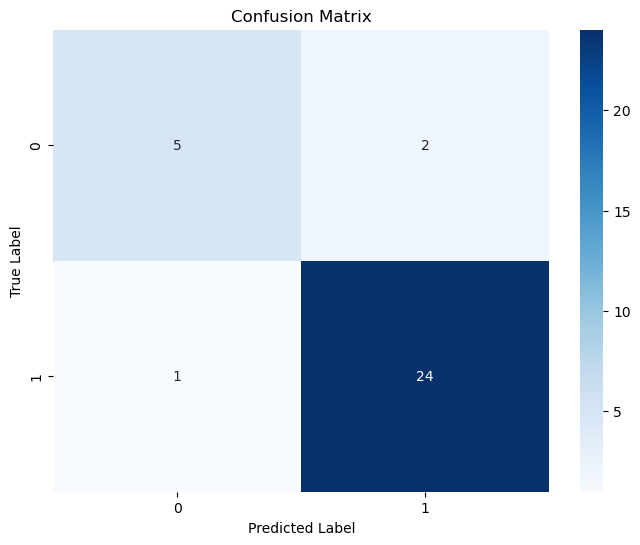

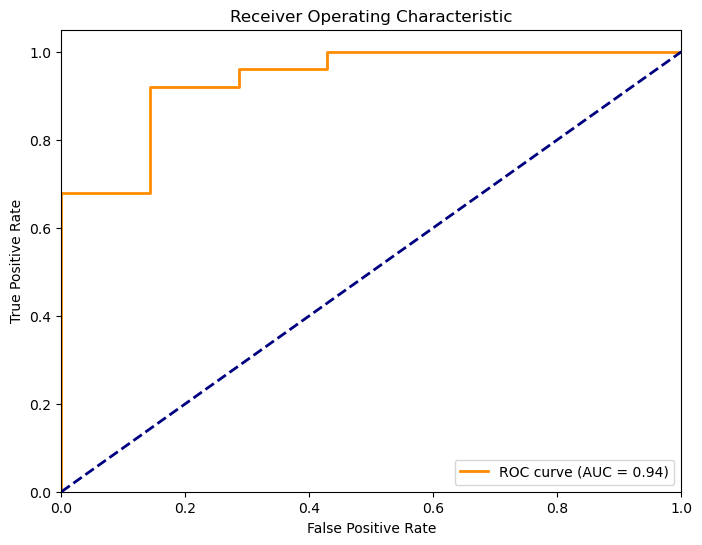

{'confusion_matrix': array([[ 5,  2],
       [ 1, 24]]), 'roc_auc': 0.937142857142857}


In [5]:
evaluation_metrics = evaluate_model(model, test_generator)
print(evaluation_metrics)

#### Analyze Errors: analyze_errors to view some misclassified cases.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


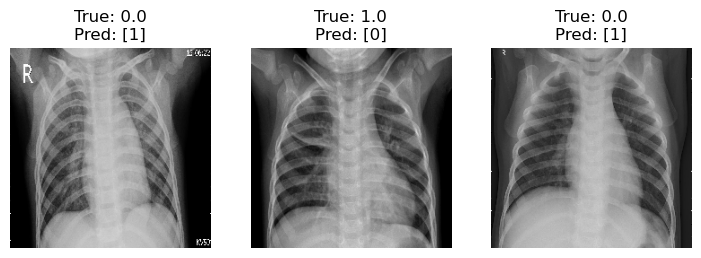

In [6]:
analyze_errors(model, test_generator, num_samples=5)
